In [22]:
from langchain_core.documents import Document
from langchain_core.retrievers import BaseRetriever
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA, RetrievalQAWithSourcesChain
from langchain.document_loaders import TextLoader
from langchain.document_loaders import DirectoryLoader
from langchain.chat_models import ChatOpenAI
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

from chromadb.utils import embedding_functions

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from dotenv import load_dotenv
from typing import List, Union
import matplotlib.pyplot as plt
import os, re, time, random
import networkx as nx
import pandas as pd
import numpy as np

import pathlib
import chromadb

import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import BootstrapFewShot, BootstrapFewShotWithRandomSearch, BootstrapFinetune

In [25]:
# Para comprobar la conexión al servidor LLaMA
!curl -X POST http://127.0.0.1:8000/generate -d '{"prompt": "Hello"}'




<!DOCTYPE HTML>
<html>

<head>
    <meta charset="utf-8">

    <title>JupyterHub</title>
    <meta http-equiv="X-UA-Compatible" content="chrome=1">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">

    
    <link rel="stylesheet" href="/hub/static/css/style.min.css?v=bff49b4a161afb17ee3b71927ce7d6c4e5b0e4b9ef6f18ca3e356a05f29e69776d3a76aee167060dd2ae2ee62d3cfdcf203b4b0090b1423f7d629ea7daa3f9da" type="text/css"/>
    
    
    <link rel="icon" href="/hub/static/favicon.ico?v=fde5757cd3892b979919d3b1faa88a410f28829feb5ba22b6cf069f2c6c98675fceef90f932e49b510e74d65c681d5846b943e7f7cc1b41867422f0481085c1f" type="image/x-icon">
    
    
    <script src="/hub/static/components/requirejs/require.js?v=bd1aa102bdb0b27fbf712b32cfcd29b016c272acf3d864ee8469376eaddd032cadcf827ff17c05a8c8e20061418fe58cf79947049f5c0dff3b4f73fcc8cad8ec" type="text/javascript" charset="utf-8"></script>
    <script src="/hub/static/components/jquery/dist/jquery.min.js?v=493a1fe319b5c2091f9bb

In [26]:
###########
#   LLM   #
###########
path_env = pathlib.Path("/export/usuarios_ml4ds/cggamella/NP-Search-Tool/.env")
print(path_env)
load_dotenv(path_env)
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

lm = dspy.HFClientTGI(model="meta-llama/Meta-Llama-3-8B ", port=8090, url="http://127.0.0.0")
#lm = dspy.OpenAI(model="gpt-3.5-turbo")# "gpt-4o-2024-05-13")

dspy.settings.configure(lm=lm, temperature = 0)

/export/usuarios_ml4ds/cggamella/NP-Search-Tool/.env


# Detección de acrónimos con dspy  (Etapa 1)

In [30]:
# Cargar dataframe donde se guardará la información 
ruta_archivo = '/export/usuarios_ml4ds/cggamella/RAG_tool/acronyms_paper.xlsx'
df = pd.read_excel(ruta_archivo)

In [31]:
df.columns

Index(['Unnamed: 0', 'acronyms', 'manual_expanded_acronyms', 'text',
       'detected_acronyms_LLaMA', 'expanded_LLaMA'],
      dtype='object')

In [32]:
df.head(2)

,Unnamed: 0,acronyms,manual_expanded_acronyms,text,detected_acronyms_LLaMA,expanded_LLaMA
0,0,ONG,Organización no gubernamental,la ong ha lanzado una campaña de concienciació...,ONG,Organización No Gubernamental
1,1,PCAP,Pliego de cláusulas administrativas particulares,el contrato de obra pública se regirá por el p...,PCAP,pliego de cláusulas administrativas particulares


In [33]:
class AcronymDetector(dspy.Signature):
    """
    Detecta los acrónimos, abreviaturas y siglas que contenga el texto. 
    
    TEXTO: La reforma del sistema tributario ha traído cambios significativos en el IVA,
    afectando tanto a consumidores como a empresarios. Las PYME han mostrado preocupación por el aumento
    de la carga fiscal, ya que sus márgenes de beneficio son más ajustados. Por otro lado, el gobierno ha
    ajustado las tasas del IRPF para aliviar la presión sobre las rentas más bajas. Según los últimos informes,
    el PIB del país ha crecido un 2% en el último trimestre, reflejando una recuperación económica gradual.
    Sin embargo, los expertos advierten que es esencial seguir monitorizando estos indicadores para evitar futuros desequilibrios.
    ACRONIMOS:IVA, PYME, IRPF, PIB 
    """
    
    TEXTO = dspy.InputField(desc="Texto en español que puede contener o no, acrónimos, siglas y/o abreviaturas que deben detectarse")
    ACRONIMOS = dspy.OutputField(desc="Lista de acrónimos, siglas y/o abreviaturas. Un acrónimo, es un tipo de palabra formada a partir de la fusión de varias palabras.")
    
class AcronymDetectorModule(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generator = dspy.Predict(AcronymDetector)

    def forward(self, texto):  
        response = self.generator(TEXTO=texto)    
        return dspy.Prediction(ACRONIMOS=response.ACRONIMOS)

In [34]:
# Crear una instancia del módulo
my_acronym_detector = AcronymDetectorModule()

# Lista para almacenar los acrónimos detectados
acronyms_detected = []

# Detectar acrónimos en cada texto del DataFrame
for index, row in df.iterrows():
    print(f"Processing row {index}: {row['text']}")
    prediction = my_acronym_detector.forward(row['text'])
    print(f"Detected acronyms: {prediction.ACRONIMOS}")
    acronyms_detected.append(prediction.ACRONIMOS)

Processing row 0: la ong ha lanzado una campaña de concienciación sobre la importancia de la protección del medio ambiente. la organización no gubernamental ha trabajado en colaboración con diferentes entidades para promover la sostenibilidad y la conservación de la biodiversidad. gracias al apoyo de voluntarios y donantes, la ong ha logrado implementar proyectos de reforestación y limpieza de playas en todo el país. su labor ha sido fundamental para sensibilizar a la población sobre la urgencia de tomar medidas para preservar nuestro entorno natural.


ConnectionError: HTTPConnectionPool(host='127.0.0.0', port=8090): Max retries exceeded with url: /generate (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f715c65cca0>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [66]:
# Guardar los acrónimos detectados
df['detected_acronyms_LLaMA'] = acronyms_detected

In [171]:
lm.inspect_history(4)




Detecta los acrónimos, abreviaturas y siglas que contenga el texto. 

TEXTO: La reforma del sistema tributario ha traído cambios significativos en el IVA,
afectando tanto a consumidores como a empresarios. Las PYME han mostrado preocupación por el aumento
de la carga fiscal, ya que sus márgenes de beneficio son más ajustados. Por otro lado, el gobierno ha
ajustado las tasas del IRPF para aliviar la presión sobre las rentas más bajas. Según los últimos informes,
el PIB del país ha crecido un 2% en el último trimestre, reflejando una recuperación económica gradual.
Sin embargo, los expertos advierten que es esencial seguir monitorizando estos indicadores para evitar futuros desequilibrios.
ACRONIMOS:IVA, PYME, IRPF, PIB

---

Follow the following format.

TEXTO: Texto en español que puede contener o no, acrónimos, siglas y/o abreviaturas que deben detectarse
ACRONIMOS: Lista de acrónimos, siglas y/o abreviaturas. Un acrónimo, es un tipo de palabra formada a partir de la fusión de vari

'\n\n\nDetecta los acrónimos, abreviaturas y siglas que contenga el texto. \n\nTEXTO: La reforma del sistema tributario ha traído cambios significativos en el IVA,\nafectando tanto a consumidores como a empresarios. Las PYME han mostrado preocupación por el aumento\nde la carga fiscal, ya que sus márgenes de beneficio son más ajustados. Por otro lado, el gobierno ha\najustado las tasas del IRPF para aliviar la presión sobre las rentas más bajas. Según los últimos informes,\nel PIB del país ha crecido un 2% en el último trimestre, reflejando una recuperación económica gradual.\nSin embargo, los expertos advierten que es esencial seguir monitorizando estos indicadores para evitar futuros desequilibrios.\nACRONIMOS:IVA, PYME, IRPF, PIB\n\n---\n\nFollow the following format.\n\nTEXTO: Texto en español que puede contener o no, acrónimos, siglas y/o abreviaturas que deben detectarse\nACRONIMOS: Lista de acrónimos, siglas y/o abreviaturas. Un acrónimo, es un tipo de palabra formada a partir d

In [69]:
# Normalizar el campo textual para evitar problemas
df['text'] = df['text'].str.lower()

# Habría que crear un identifier único de los docs en futuras versiones

In [ ]:
# Crear el text splitter, [chunk_size: #caracteres de cada chunk];
#[chunk_overlap: #caracteres solapan entre chunks para no perder info.]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=200)

# Crear una lista para almacenar los documentos
documents = []
# Procesar cada fila como un documento separado
for idx, row in df.iterrows():
    example_document = row['text']
    print("el example doc es:",example_document)
    doc = Document(page_content=example_document, metadata={"url": "local", "source": "initial"}) #, "identifier": row['identifier']})
    print("El doc es:",doc)
    # Dividir el documento en fragmentos
    chunks = text_splitter.split_text(doc.page_content)
    print("Los chunks son:",chunks)
    for chunk in chunks:
        chunk_doc = Document(page_content=chunk, metadata=doc.metadata)
        print("EL chunk_doc es:\n",chunk_doc)
        documents.append(chunk_doc)

# Create database 

In [16]:
# Create database only the firt time. Be careful!
# Embed and store the texts
path_to_index = '/export/usuarios_ml4ds/cggamella/RAG_tool'
# Supplying a persist_directory will store the embeddings on disk
persist_directory = (pathlib.Path(path_to_index) / 'db_POC_acronyms').as_posix()

In [17]:
path_env = pathlib.Path("/export/usuarios_ml4ds/cggamella/NP-Search-Tool/.env")
print(path_env)
load_dotenv(path_env)
api_key = os.getenv("HUGGINGFACE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"] = api_key

/export/usuarios_ml4ds/cggamella/NP-Search-Tool/.env


In [18]:
# Calcular los embeddings con un modelo de uso libre de HuggingFace
# Using HuggingFace models. The embedding function a huggingface api_key
huggingface_ef = embedding_functions.HuggingFaceEmbeddingFunction(
    api_key="HUGGINGFACE_API_KEY", 
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

start = time.time()
# Almacenar los fragmentos en una base de datos vectorial usando Chroma
# Se extrae el contenido (page_content).El contenido se pasa a OpenAIEmbeddings
# para obtener los embeddings. El vector resultante se almacena en la base de datos junto con los metadatos(índices).
vectordb = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    persist_directory=persist_directory 
)
end = time.time()
print(f"Total time is {end - start} seconds")

NameError: name 'documents' is not defined

# Cargar la bbdd ya creada

In [19]:
vectordb = Chroma(persist_directory=persist_directory)

In [20]:
results = vectordb.get(limit=100, include=['documents', 'embeddings'])

In [21]:
results

{'ids': ['02d1460e-0fdd-40af-9a08-eac42ade08c9',
  '02d17c8c-d380-49bf-b1c8-5e716dedc38b',
  '03178758-1600-465f-b752-58bb55fca7d7',
  '05a08401-80e1-4098-9569-477bb2f4ab4a',
  '06f650c0-f08f-48f7-a6a9-77efdf3cd9ac',
  '11eb811e-5db0-4743-b5d2-6f486f009882',
  '123e6a3b-872e-40ab-bcd3-ef122cb502bb',
  '13b689ef-6bab-4f69-a5d5-dda0ab556ac2',
  '15c8b706-20cb-4cd9-8a0f-50c989307412',
  '15de934a-6698-4e3d-bde9-98b5e477b260',
  '1d06da59-4f0b-41ee-a0c1-8954002f4b41',
  '1dd051cb-f2f8-43c0-ae97-4cdb29969c5c',
  '1e6e1d0a-d3d6-4b09-9c8e-e6800b96e1fb',
  '2e22fd7a-9f51-4606-997e-ef6b2401d60f',
  '319a993d-8668-413b-a605-5da98aca1b89',
  '33ddaf30-122c-4155-8e5f-7b97499967fc',
  '34e7f4fc-536c-49bf-b96a-de71415e34fa',
  '35e2bfa3-5bfa-40e8-a849-43366b14a88a',
  '3a18e9c7-358f-4028-9819-67edeccb6be3',
  '4097875b-d9de-4eae-8740-bbf2f6129a57',
  '41b85525-5802-47ce-bb7b-1e5d637da3d8',
  '423708cb-7da9-41a4-8502-47b64215bfda',
  '43a6ee19-e487-4f04-b2e6-87992e9612b3',
  '45530a3c-f0ea-47ab-b7da-

# Custom Retrieval Module

In [226]:
class AcronymAwareRetriever(dspy.Retrieve):
    """
    Custom retriever for searching documents containing a specific acronym.
    """
    def __init__(self, vectordb, k:int = 3):
        super().__init__(k=k)
        self.vectordb = vectordb

    def forward(self, acronym: Union[str, List[str]], k: int = None) -> dspy.Prediction:
        """
        Retrieve documents containing the provided acronym by directly querying
        the vector database. The documents are filtered to include only those
        where the acronym appears as a standalone word.
        """
        # Creating regex to match the acronym as a standalone word
        regex = r'\b' + re.escape(acronym) + r'\b'

        # Retrieve documents that might contain the acronym
        results = self.vectordb.get(where_document={"$contains": acronym}, limit=k if k else self.k, 
                                    include=['documents', 'embeddings'])

        # Extract relevant information
        documents = results.get('documents', [])
        embeddings = results.get('embeddings', [])

         # Filter documents and their embeddings using regex, avoiding duplicates
        seen_documents = set() 
        filtered_documents = []
        filtered_embeddings = []
        filtered_passages = []

        for doc, emb in zip(documents, embeddings):
            # Check if the document contains the acronym as a standalone word and is not already added
            if re.search(regex, doc, re.IGNORECASE) and doc not in seen_documents:
                seen_documents.add(doc)
                filtered_documents.append(doc)
                filtered_embeddings.append(emb)
                # Extract passages for documents that pass the regex check
                filtered_passages.append(self.extract_passages(doc, acronym))

        # Return the results wrapped in a dspy.Prediction object
        return dspy.Prediction(documents=filtered_documents, embeddings=filtered_embeddings, passages=filtered_passages)

    def extract_passages(self, text, acronym):
        """
        Extrae las dos frases anteriores y las 2 posteriores después de la primera aparición del
        acrónimo en el texto.
        """
        sentences = sent_tokenize(text)
        for i, sentence in enumerate(sentences):
            if acronym.lower() in sentence.lower():
                # Encontrar un rango de frases alrededor de la aparición del acrónimo
                start = max(i - 2, 0)
                end = min(i + 3, len(sentences))
                return ' '.join(sentences[start:end])
        return ""  

# Desambiguación de acrónimos con dspy (Etapa 2)

In [352]:
class AcronymExpander(dspy.Signature):
    """
    Expande los acrónimos basándose en el contexto del texto.
    
    TEXTO: Las antenas que operan en la banda de los 60 Ghz se dice que funcionan en la banda de ondas milimétricas, pues bien su longitud de onda está en el orden de los milímetros.
    
    ACRONIMO: ghz
    EXPANSION: gigahercio
    """
    
    TEXTO = dspy.InputField(desc="Texto que contiene el acrónimo,sigla o abreviatura y aporta información sobre la forma expandida")
    ACRONIMO = dspy.InputField(desc="Acrónimo que necesita ser expandido")
    EXPANSION = dspy.OutputField(desc="Es la forma expandida del acrónimo")
    
class AcronymExpanderModule(dspy.Module):
    def __init__(self):
        super().__init__()
        self.expander = dspy.Predict(AcronymExpander)

    def forward(self, **inputs):  
        texto = inputs.get('TEXTO')
        acronimo = inputs.get('ACRONIMO')
        response = self.expander(TEXTO=texto, ACRONIMO=acronimo)    
        return dspy.Prediction(EXPANSION=response.EXPANSION)

# Disambiguation logic

In [99]:
acronym_retriever = AcronymAwareRetriever(vectordb=vectordb, k=5)
acronym_expander = AcronymExpanderModule()

# Creo nueva columna en el df para guardar los acrónimos expandidos
df['expanded_LLaMA'] = 'None'

for index, row in df.iterrows():
    text = row['text']
    # Los acrónimos están separados por comas si se detecta más de uno.
    detected_acronyms = str(row['detected_acronyms_LLaMA']).lower().split(',')
    detected_acronyms = [acronym.strip() for acronym in detected_acronyms if acronym.strip() not in ['', 'n/a', 'none', 'ninguno']]

    # Lista para mantener las expansiones de acrónimos encontrados
    expansions = []

    for acronym in detected_acronyms:
        # Recuperar documentos relevantes utilizando el retriever
        retrieved_docs = acronym_retriever.forward(acronym).passages

        # Concatenar todos los docs retrieval
        concatenated_docs = " ".join(retrieved_docs)  
        # Usar docs concatenados
        if concatenated_docs: 
            expansion_result = acronym_expander.forward(concatenated_docs, acronym)
            expansions.append(expansion_result.EXPANSION)

    # Guardar las expansiones en la columna 'expanded_LLaMA'
    df.at[index, 'expanded_LLaMA'] = ', '.join(expansions)

{'ids': ['34e7f4fc-536c-49bf-b96a-de71415e34fa', '53c6ca0d-5979-4a79-b993-c1fb5069074b'], 'embeddings': None, 'metadatas': [{'source': 'initial', 'url': 'local'}, {'source': 'initial', 'url': 'local'}], 'documents': ['la ong ha lanzado una campaña de concienciación sobre la importancia de la protección del medio ambiente. la organización no gubernamental ha trabajado en colaboración con diferentes entidades para promover la sostenibilidad y la conservación de la biodiversidad. gracias al apoyo de voluntarios y donantes, la ong ha logrado implementar proyectos de reforestación y limpieza de playas en todo el país. su labor ha sido fundamental para sensibilizar a la población sobre la urgencia de tomar medidas para preservar nuestro entorno natural.', 'el accidente ocurrió en el pk 50 de la autopista, causando un gran congestionamiento de tráfico. los servicios de emergencia llegaron rápidamente al lugar para atender a los heridos y restablecer la circulación. la policía investiga las ca

{'ids': ['c1fd5b94-ba82-44c7-a8e5-564049f569e9'], 'embeddings': None, 'metadatas': [{'source': 'initial', 'url': 'local'}], 'documents': ['la comisión nacional del mercado de valores (cnmv) es el organismo encargado de supervisar e inspeccionar los mercados de valores en españa. su principal objetivo es garantizar la transparencia y la protección de los inversores, velando por el correcto funcionamiento de los mercados financieros. la cnmv se encarga de regular la actividad de las entidades financieras y de velar por el cumplimiento de la normativa vigente en materia de valores. su labor es fundamental para mantener la confianza en el sistema financiero y para prevenir posibles abusos o fraudes en el mercado de valores.'], 'uris': None, 'data': None}
{'ids': ['65be4c49-26fa-450d-a60b-a8d17e6ae36f'], 'embeddings': None, 'metadatas': [{'source': 'initial', 'url': 'local'}], 'documents': ['el ministerio de hacienda y administraciones públicas (minhac) ha anunciado nuevas medidas para mejo

{'ids': ['f1504844-5f1e-4829-9c67-d2a32c5a9658'], 'embeddings': None, 'metadatas': [{'source': 'initial', 'url': 'local'}], 'documents': ['la empresa de transporte ferroviario renfe ha anunciado la incorporación de trenes de alta velocidad en varias rutas, con el objetivo de mejorar la conectividad entre ciudades y reducir los tiempos de viaje. esta medida forma parte de su plan de modernización y expansión, que busca aumentar la satisfacción de los usuarios y fomentar el uso del transporte público. además, renfe ha implementado nuevas medidas de seguridad y limpieza en sus estaciones y trenes, en respuesta a la pandemia de covid-19.'], 'uris': None, 'data': None}
{'ids': ['f1504844-5f1e-4829-9c67-d2a32c5a9658'], 'embeddings': None, 'metadatas': [{'source': 'initial', 'url': 'local'}], 'documents': ['la empresa de transporte ferroviario renfe ha anunciado la incorporación de trenes de alta velocidad en varias rutas, con el objetivo de mejorar la conectividad entre ciudades y reducir lo

In [103]:
#df.to_excel('/export/usuarios_ml4ds/cggamella/RAG_tool/acronyms_paper.xlsx')

# Integración de grafos de conocimiento para desambiguación de contextos

In [232]:
class GraphVisualizer:
    def __init__(self, kernel='umbral', threshold=0.21, symmetric=True, remove_self_links=True):
        self.kernel = kernel
        self.threshold = threshold
        self.symmetric = symmetric
        self.remove_self_links = remove_self_links

    def set_embeddings(self, embeddings):
        self.embeddings = np.array(embeddings)

    def _get_similarity_matrix(self):
        if self.embeddings is None:
            raise ValueError("Embeddings not set. Please set embeddings before trying to get similarity matrix.")
        similarity_matrix = cosine_similarity(self.embeddings)
        print(similarity_matrix)
        if self.kernel == "umbral":
            similarity_matrix[similarity_matrix < self.threshold] = 0
        if self.remove_self_links:
            np.fill_diagonal(similarity_matrix, 0)
        return similarity_matrix

    def visualize_graph(self, plot_graph=True):
        similarity_matrix = self._get_similarity_matrix()
        G = nx.from_numpy_array(similarity_matrix, create_using=nx.DiGraph)

        if plot_graph:
            pos = nx.spring_layout(G, seed=42)
            nx.draw(G, pos, node_color='skyblue', with_labels=True, node_size=70, edge_color='blue', width=0.4)
            plt.title("Document Similarity Graph")
            plt.show()
        
        return {
            'number_of_nodes': G.number_of_nodes(),
            'number_of_edges': G.number_of_edges(),
            'edges_per_node': G.number_of_edges() / G.number_of_nodes()
        }

    def perform_clustering(self):
        if self.embeddings is None:
            raise ValueError("Embeddings not set. Please set embeddings before trying to perform clustering.")
        self.linkage_matrix = linkage(self.embeddings, method='ward')

    def plot_dendrogram(self, title='Dendrograma de Clustering Jerárquico'):
        if not hasattr(self, 'linkage_matrix'):
            raise ValueError("Clustering not performed yet. Use `perform_clustering` method first.")
        plt.figure(figsize=(10, 7))
        dendrogram(self.linkage_matrix)
        plt.title(title)
        plt.xlabel('Índice del Documento')
        plt.ylabel('Distancia de Ward')
        plt.show()

[[1.         0.57364768 0.55717654]
 [0.57364768 1.         0.39173099]
 [0.55717654 0.39173099 1.        ]]


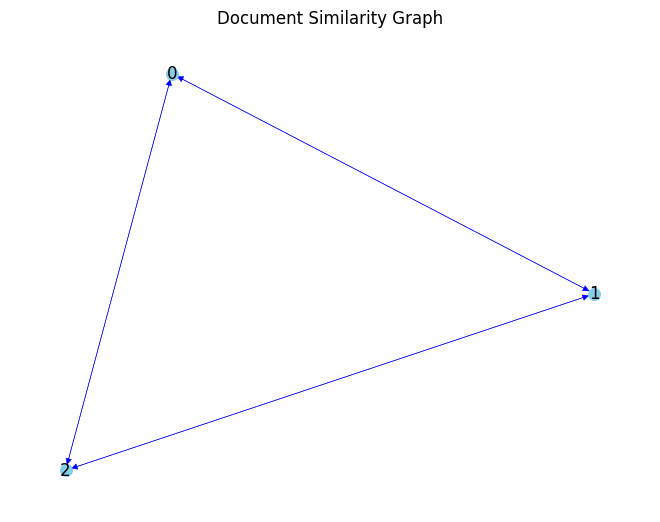

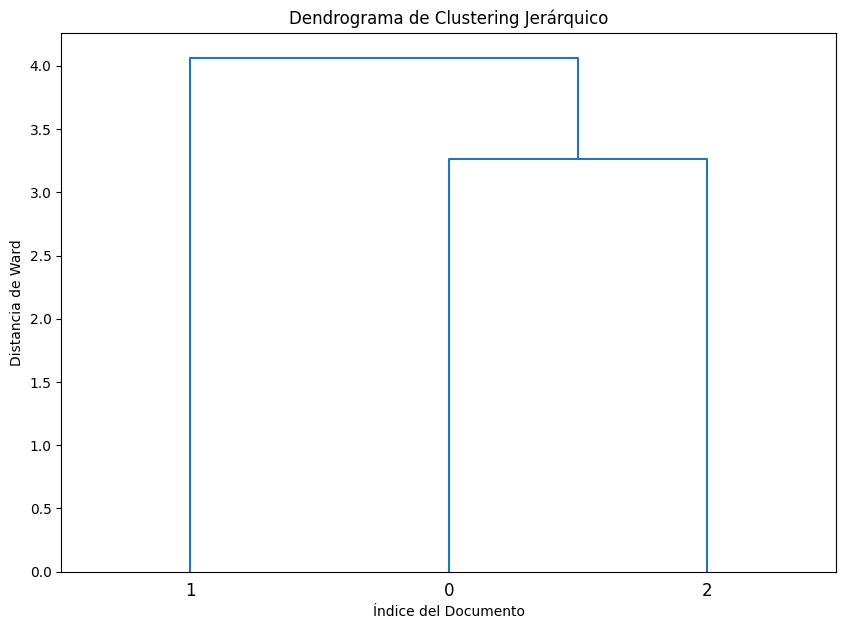

In [339]:
result_predict = acronym_retriever.forward("pdf")

# Instanciar y configurar GraphVisualizer
visualizer = GraphVisualizer()
visualizer.set_embeddings(result_predict.embeddings)

# Visualizar el grafo de similitud
visualizer.visualize_graph()

# Realizar clustering jerárquico y visualizar el dendrograma
visualizer.perform_clustering()
visualizer.plot_dendrogram()

# Crear dataset de entrenamiento y validación

In [13]:
def create_dtset_expanded_acronyms(excel_path):
    # Cargar datos desde un archivo Excel
    df = pd.read_excel(excel_path)

    # Limpiar y seleccionar las columnas necesarias
    df = df[['acronyms', 'manual_expanded_acronyms', 'text', 'expanded_LLaMA']]
    
    # Convert the DataFrame into a list of dictionaries
    data = []
    for i, row in df.iterrows():
        data.append({
            "id": i,
            "TEXTO": row["text"],
            "ACRONIMO": row["acronyms"],
            "EXPANSION": row["expanded_LLaMA"],
        })
        
    # Convert the list of dictionaries back into a DataFrame
    data_df = pd.DataFrame(data)

    # Dividir los datos en conjuntos de entrenamiento y validación
    train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

    # Convertir los DataFrames de entrenamiento y validación en listas de diccionarios
    data_train = train_df.to_dict('records')
    data_test = test_df.to_dict('records')

    # Create training examples
    trainset = [
        dspy.Example({**row}).with_inputs('TEXTO', 'ACRONIMO', 'EXPANSION') for row in data_train
    ]
    # Create development examples
    devset = [
        dspy.Example({**row}).with_inputs('TEXTO', 'ACRONIMO', 'EXPANSION') for row in data_test
    ]

    return trainset, devset

In [14]:
trainset

NameError: name 'trainset' is not defined

In [355]:
# Usar la clase
excel_path = '/export/usuarios_ml4ds/cggamella/RAG_tool/acronyms_paper.xlsx'

# Definir la función de validación ajustada
def validate_expansion(example, prediction):
    expected = example.output('EXPANSION')  # Obtener el valor esperado correctamente
    predicted = prediction.outputs['EXPANSION']
    return expected == predicted

acronym_module = AcronymExpanderModule()

teleprompter = BootstrapFewShotWithRandomSearch(
    metric=validate_expansion,
    max_bootstrapped_demos=4,  # Máximo de ejemplos demostrativos durante el arranque
    max_labeled_demos=16,      # Máximo de ejemplos con etiquetas durante la búsqueda
    num_candidate_programs=16, # Número de programas candidatos a evaluar
    max_rounds=1,              # Máximo de rondas de evaluación
)

# Cargar los conjuntos de entrenamiento y validación
trainset, devset = create_dtset_expanded_acronyms(excel_path)

2024-07-15T15:32:54.510501Z [error    ] Error for example in dev set: 		 'Example' object has no attribute 'output' [dspy.evaluate.evaluate] filename=evaluate.py lineno=180
2024-07-15T15:32:54.527055Z [error    ] Error for example in dev set: 		 'Example' object has no attribute 'output' [dspy.evaluate.evaluate] filename=evaluate.py lineno=180
2024-07-15T15:32:54.530469Z [error    ] Error for example in dev set: 		 'Example' object has no attribute 'output' [dspy.evaluate.evaluate] filename=evaluate.py lineno=180
Average Metric: 0.0 / 6  (0.0): 100%|████████████| 6/6 [00:00<00:00, 425.23it/s]
2024-07-15T15:32:54.584938Z [error    ] Error for example in dev set: 		 Received invalid JSON response from server [dspy.evaluate.evaluate] filename=evaluate.py lineno=180
2024-07-15T15:32:54.598793Z [error    ] Error for example in dev set: 		 Received invalid JSON response from server [dspy.evaluate.evaluate] filename=evaluate.py lineno=180


Failed to parse JSON response: {"error":"Request failed during generation: Server error: CANCELLED","error_type":"generation"}
Failed to parse JSON response: {"error":"Request failed during generation: Server error: error trying to connect: Connection refused (os error 111)","error_type":"generation"}
Failed to parse JSON response: {"error":"Request failed during generation: Server error: CANCELLED","error_type":"generation"}


2024-07-15T15:32:54.610795Z [error    ] Error for example in dev set: 		 Received invalid JSON response from server [dspy.evaluate.evaluate] filename=evaluate.py lineno=180
  0%|                                                     | 0/6 [00:00<?, ?it/s]2024-07-15T15:32:54.619756Z [error    ] Error for example in dev set: 		 Received invalid JSON response from server [dspy.evaluate.evaluate] filename=evaluate.py lineno=180
2024-07-15T15:32:54.623809Z [error    ] Error for example in dev set: 		 Received invalid JSON response from server [dspy.evaluate.evaluate] filename=evaluate.py lineno=180
Average Metric: 0.0 / 6  (0.0): 100%|████████████| 6/6 [00:00<00:00, 436.47it/s]


Failed to parse JSON response: {"error":"Request failed during generation: Server error: error trying to connect: Connection refused (os error 111)","error_type":"generation"}
Failed to parse JSON response: {"error":"Request failed during generation: Server error: error trying to connect: Connection refused (os error 111)","error_type":"generation"}
Failed to parse JSON response: {"error":"Request failed during generation: Server error: error trying to connect: Connection refused (os error 111)","error_type":"generation"}


  0%|                                                    | 0/23 [00:00<?, ?it/s]2024-07-15T15:32:54.663269Z [error    ] Failed to run or to evaluate example Example({'id': 21, 'TEXTO': 'el spee es el encargado de gestionar el empleo en españa, facilitando la inserción laboral de los ciudadanos. gracias a sus programas de formación y orientación, el spee ayuda a reducir la tasa de desempleo en el país. además, colabora estrechamente con las empresas para promover la contratación de trabajadores a través de medidas como los incentivos a la contratación. sin embargo, es importante seguir mejorando la eficacia del spee para garantizar un mercado laboral más dinámico y competitivo.', 'ACRONIMO': 'SEPE', 'EXPANSION': 'Servicio Público de Empleo Estatal Español'}) (input_keys={'ACRONIMO', 'TEXTO', 'EXPANSION'}) with <function validate_expansion at 0x7fb6c2fd8c10> due to HTTPConnectionPool(host='127.0.0.0', port=8090): Max retries exceeded with url: /generate (Caused by NewConnectionError('<ur

ConnectionError: HTTPConnectionPool(host='127.0.0.0', port=8090): Max retries exceeded with url: /generate (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb6c2fb4520>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
# Compilar el clasificador usando el teleprompter
compiled_model = teleprompter.compile(
    acronym_module,
    trainset=trainset,
    valset=devset
)